<a href="https://colab.research.google.com/github/NiceAsiv/Homework/blob/main/XJTU/AdvAI/Improved_Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IDLG（Improved Deep Leakage from Gradients）是在DLG方法的基础上进行改进。我们发现共享梯度肯定会泄露ground-truth的标签。我们提出了一种简单而可靠的方法来从梯度中提取准确的数据。特别是，相对于DLG来说，我们的方法肯定能提取出真实的标签，因此我们将其命名为改进的DLG（iDLG）。
项目地址：https://github.com/PatrickZH/Improved-Deep-Leakage-from-Gradients/tree/master

In [ ]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import pickle
import PIL.Image as Image
import torchvision

torch.manual_seed(50)
print(torch.__version__, torchvision.__version__)

2.5.1+cu121 0.20.1+cu121


In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

In [ ]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    # forward method
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#===============初始化权重=================
def weights_init(m):
    try:
        # hasattr()函数 用于判断对象是否包含对应的属性。
        if hasattr(m, "weight"):
            # 使用均匀分布U(a,b)初始化Tensor，即Tensor的填充值是等概率的范围为 [a，b) 的值。均值为 （a + b）/ 2.
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.weight' % m._get_name())
    try:
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.bias' % m._get_name())

In [ ]:
def load_data(dataset, root_path):
    data_path = os.path.join(root_path, './torch/%s'%dataset).replace('\\', '/')
    if dataset == 'MNIST':
        shape_img = (28, 28)
        num_classes = 10
        channel = 1
        hidden = 588
        dst = datasets.MNIST(data_path, download=True)
    elif dataset == 'cifar100':
        shape_img = (32, 32)
        num_classes = 100
        channel = 3
        hidden = 768
        dst = datasets.CIFAR100(data_path, download=True)
    else:
        exit('unknown dataset')
    return dst, shape_img, num_classes, channel, hidden


def train_iDLG(net, gt_data, gt_label, original_dy_dx, device, lr=1.0, Iteration=300):

    # Initialize dummy data
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,))
    optimizer = torch.optim.LBFGS([dummy_data], lr=lr)

    criterion = nn.CrossEntropyLoss().to(device)

    # Training loop
    losses, mses = [], []
    for iters in range(Iteration):
        def closure():
            optimizer.zero_grad()
            pred = net(dummy_data)
            dummy_loss = criterion(pred, label_pred)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        losses.append(current_loss)
        mses.append(torch.mean((dummy_data - gt_data) ** 2).item())
       # 动态显示中间结果图像
        # if iters % 50 == 0:
        #     plot_dummy_data(dummy_data, iters, dataset)

        if current_loss < 1e-6:
            break

    return losses, mses, dummy_data

def train_DLG(net, gt_data, gt_label, original_dy_dx, num_classes, device, lr=1.0, Iteration=300):
    # Initialize dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=lr)

    criterion = nn.CrossEntropyLoss().to(device)

    # Training loop
    losses, mses = [], []
    for iters in range(Iteration):
        def closure():
            optimizer.zero_grad()
            pred = net(dummy_data)
            dummy_loss = - torch.mean(torch.sum(torch.softmax(dummy_label, -1) * torch.log(torch.softmax(pred, -1)), dim=-1))
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        losses.append(current_loss)
        mses.append(torch.mean((dummy_data - gt_data) ** 2).item())

        if iters % 50 == 0:
            plot_dummy_data(dummy_data, iters, dataset)

        if current_loss < 1e-6:
            break

    return losses, mses, dummy_data

def compute_original_gradient(net, gt_data, gt_label, criterion):
    out = net(gt_data)
    y = criterion(out, gt_label)

    # 计算y关于参数的梯度
    dy_dx = torch.autograd.grad(y, net.parameters())
    # 将所有参数的梯度克隆存储为列表
    original_dy_dx = [param_grad.detach().clone() for param_grad in dy_dx]
    return original_dy_dx

def plot_results(losses, mses, dummy_data, gt_data, dataset):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title('Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(mses)
    plt.title('MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(dummy_data.detach().cpu().numpy().reshape(gt_data.shape), (0, 2, 3, 1))[0])
    plt.title('Dummy Data')
    plt.axis('off')
    plt.show()

# 函数：直接显示 Ground Truth 图像
def plot_ground_truth(gt_data, dataset):
    """
    显示需要重组的原始图像（Ground Truth）
    """
    for idx, gt in enumerate(gt_data):
        img = gt.detach().cpu().numpy().reshape(gt.shape[1], gt.shape[2])
        plt.imshow(img, cmap='gray' if dataset == 'MNIST' else None)
        plt.axis('off')
        plt.title(f'Ground Truth {idx + 1}')
        plt.show()


# 函数：在训练过程中动态显示 Dummy Data 图像
def plot_dummy_data(dummy_data, iteration, dataset):
    """
    显示重组过程中 Dummy Data 的图像
    """
    dummy_img = dummy_data.detach().cpu().numpy().reshape(dummy_data.shape[2], dummy_data.shape[3])
    plt.imshow(dummy_img, cmap='gray' if dataset == 'MNIST' else None)
    plt.axis('off')
    plt.title(f'Dummy Data at Iteration {iteration}')
    plt.show()

/results/iDLG_MNIST
/torch/MNIST
MNIST root_path: ~
MNIST data_path: /torch/MNIST
MNIST save_path: /results/iDLG_MNIST
running 0|5 experiment


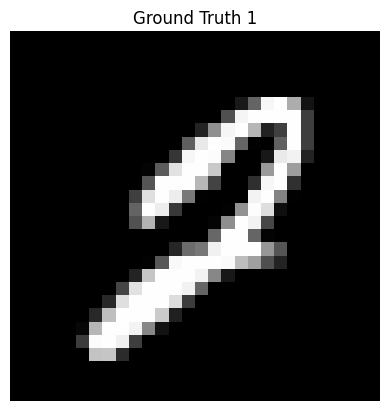

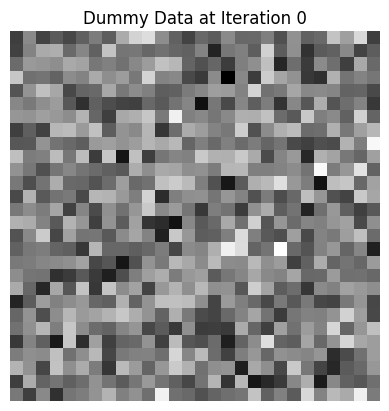

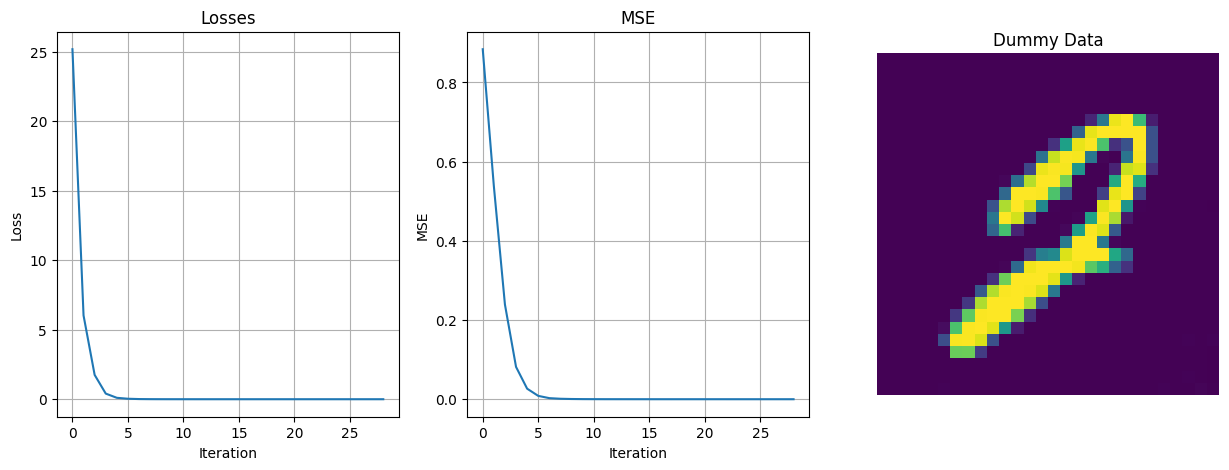

DLG Final Loss: 9.248073524759093e-07, MSE: 2.7856881956722646e-07


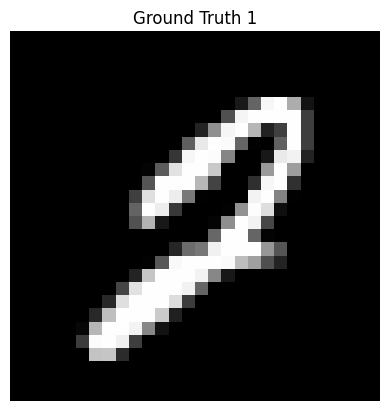

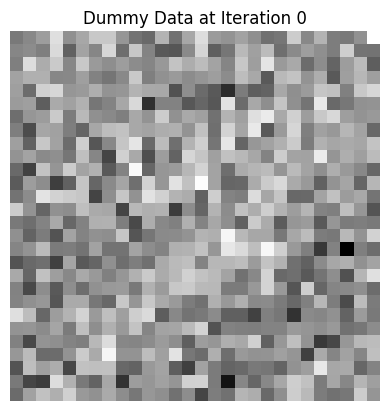

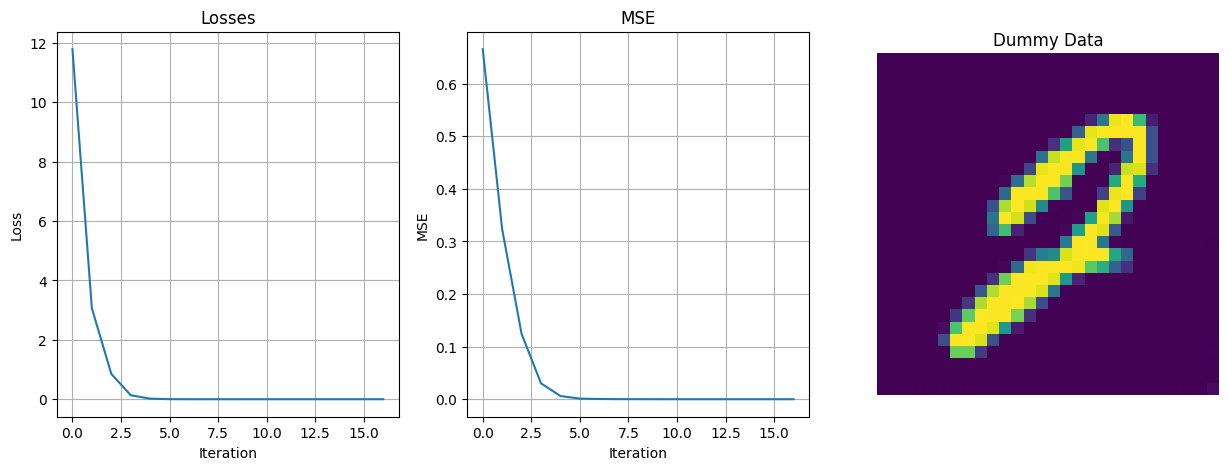

iDLG Final Loss: 6.807408681197558e-07, MSE: 1.0434927162350505e-06
running 1|5 experiment


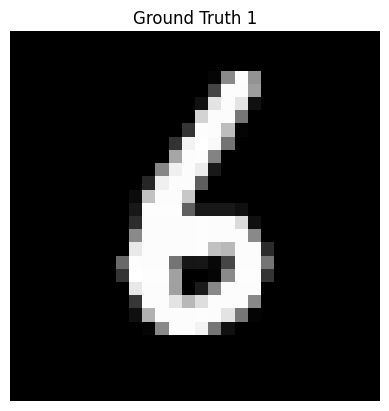

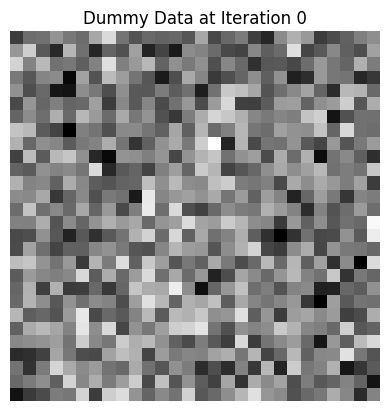

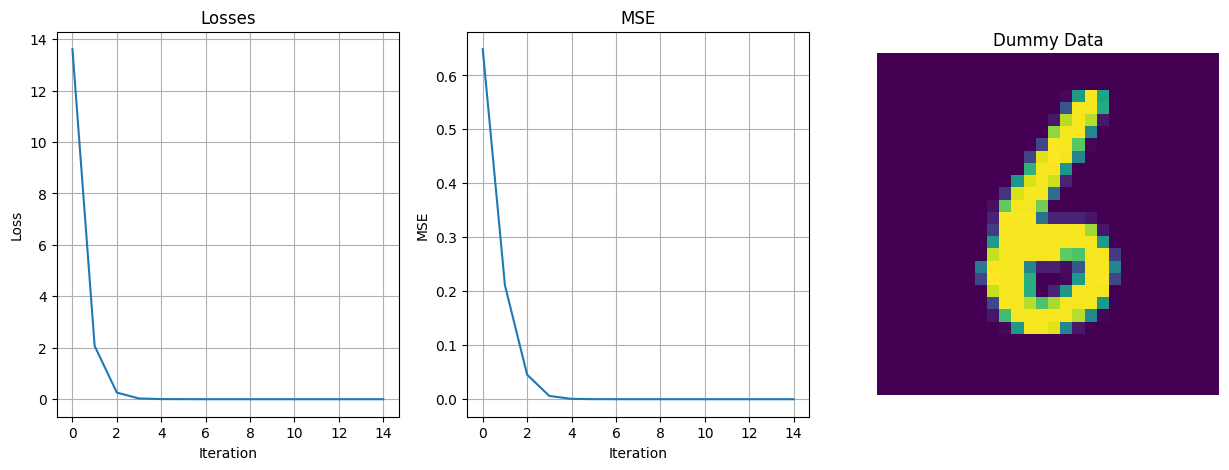

DLG Final Loss: 4.001458648872358e-07, MSE: 4.783198193081262e-08


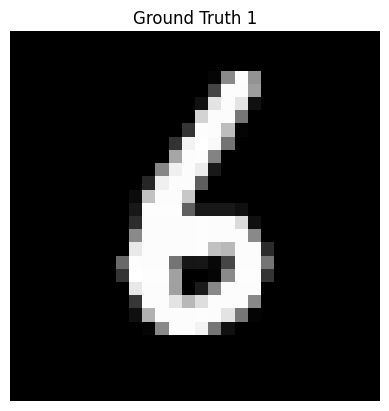

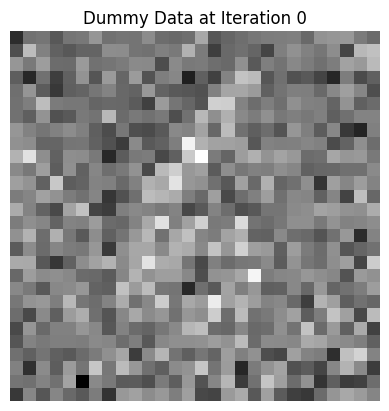

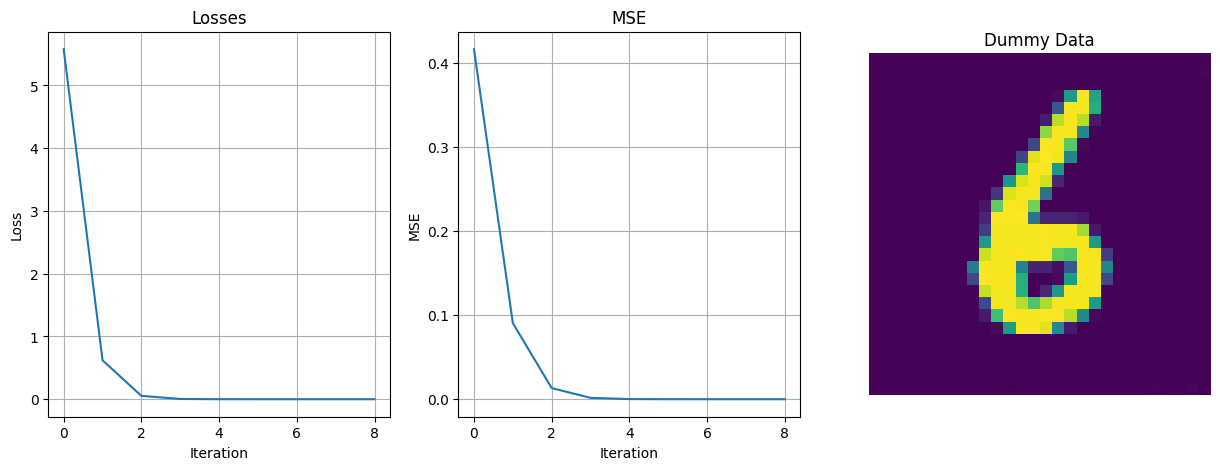

iDLG Final Loss: 4.71089805387237e-07, MSE: 2.4867321712918056e-07
running 2|5 experiment


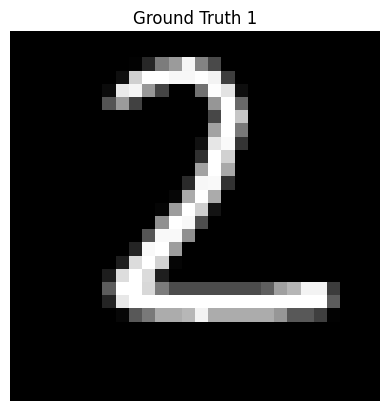

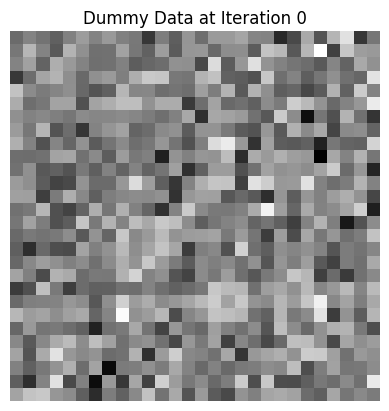

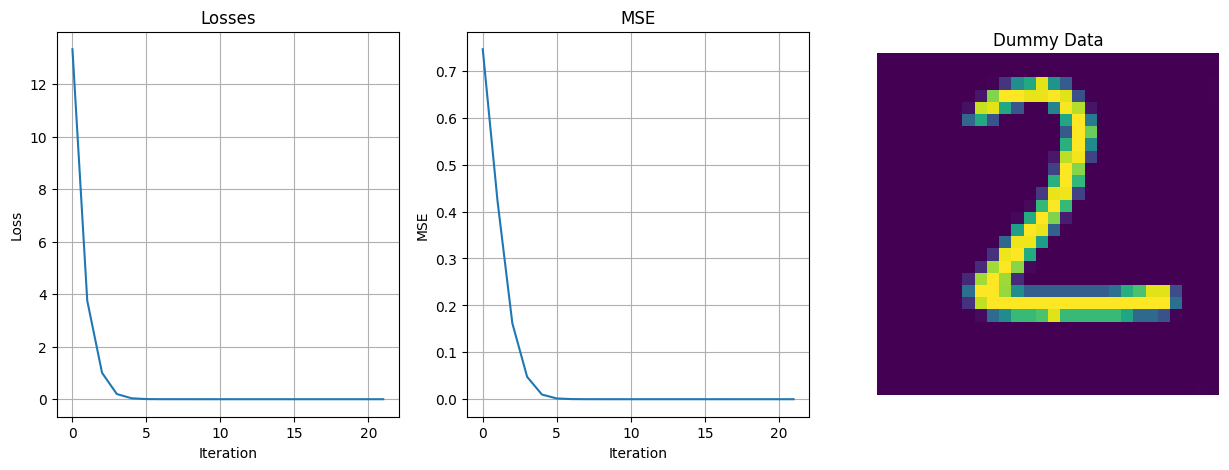

DLG Final Loss: 5.333776016414049e-07, MSE: 9.69128777228434e-08


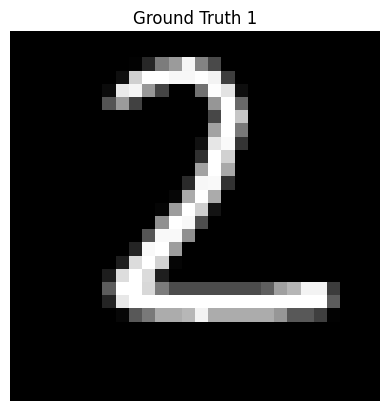

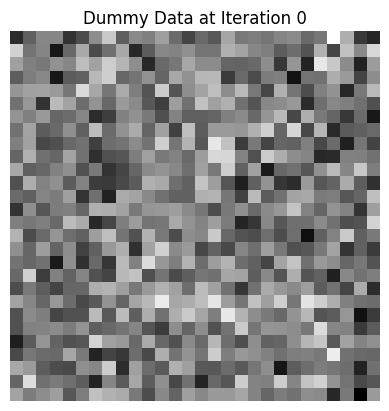

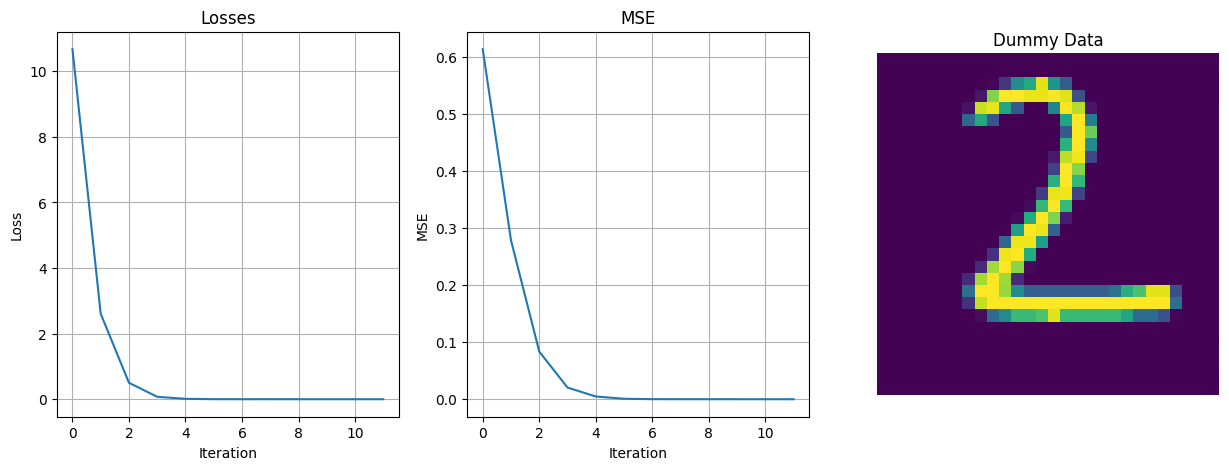

iDLG Final Loss: 3.614135835050547e-07, MSE: 2.0799571132101846e-07
running 3|5 experiment


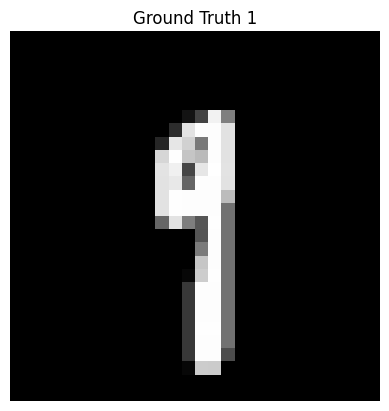

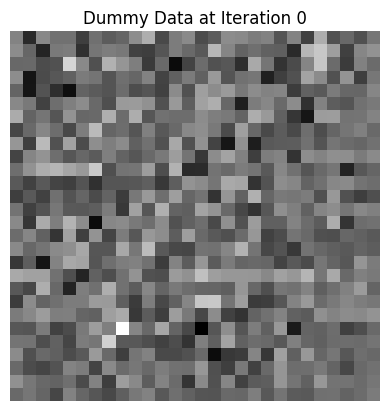

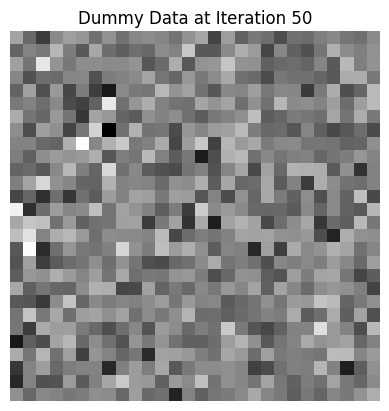

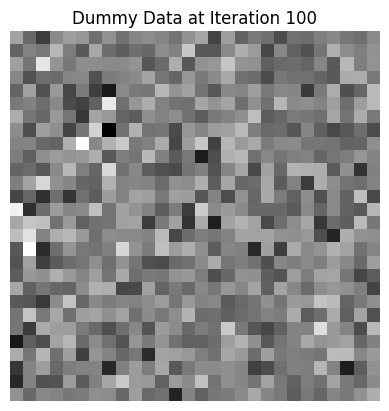

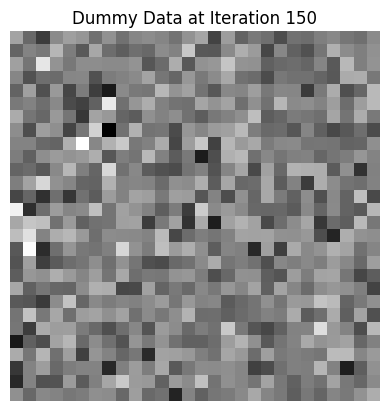

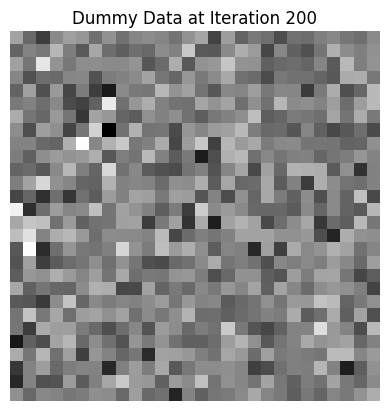

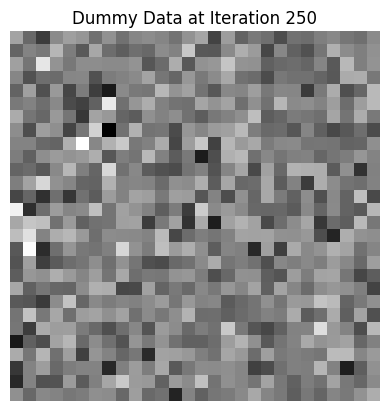

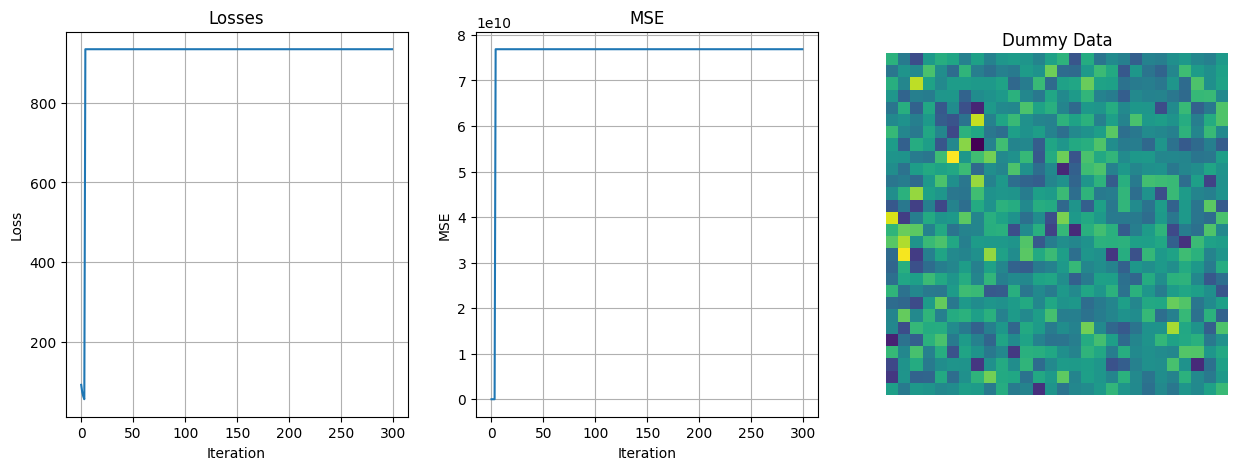

DLG Final Loss: 933.7068481445312, MSE: 76865290240.0


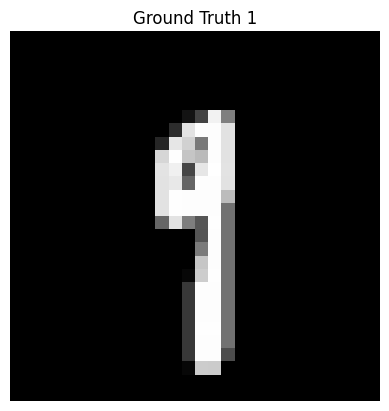

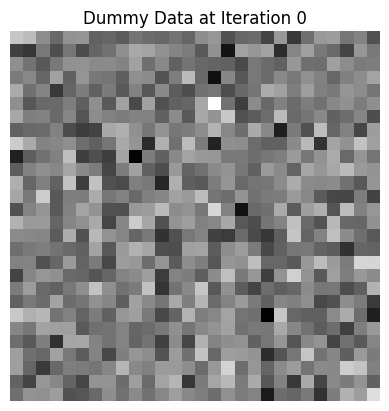

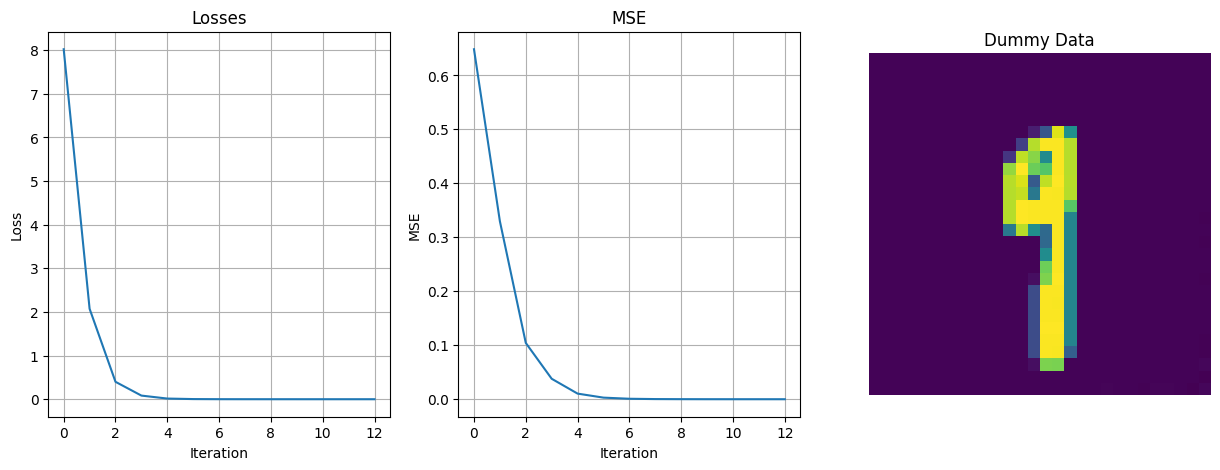

iDLG Final Loss: 8.520283358848246e-07, MSE: 6.71548093578167e-07
running 4|5 experiment


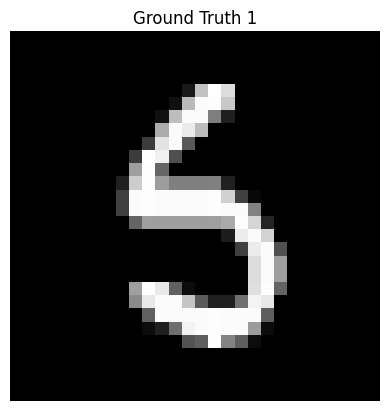

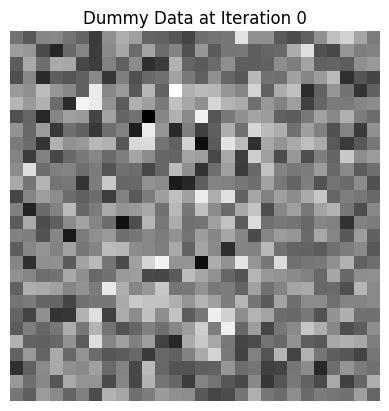

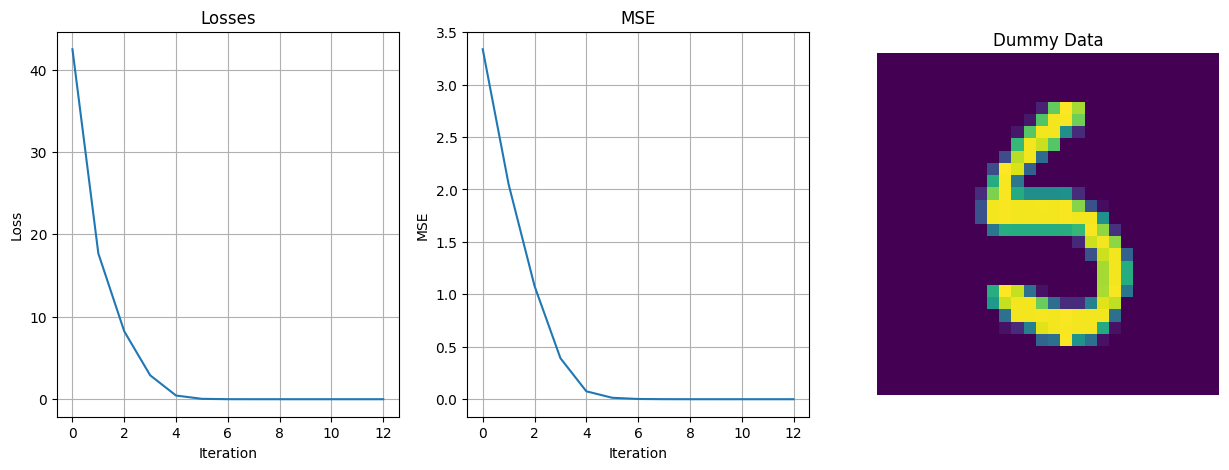

DLG Final Loss: 9.957666691207123e-08, MSE: 3.145541072058222e-08


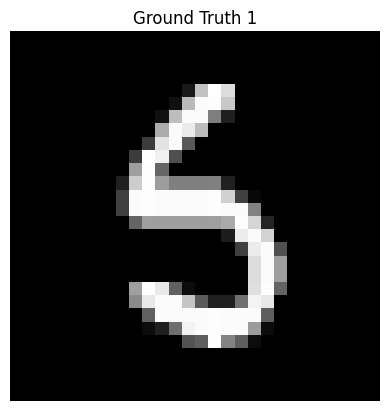

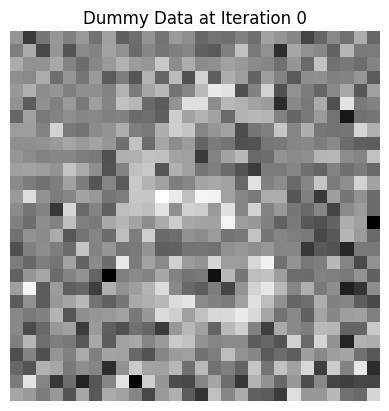

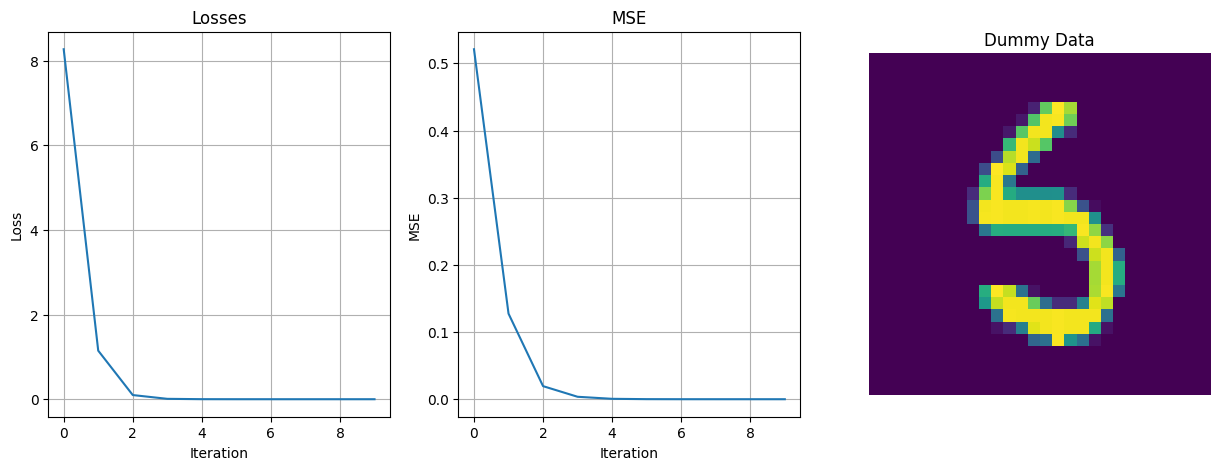

iDLG Final Loss: 1.1193872495596224e-07, MSE: 2.8683333042067716e-08


In [ ]:
dataset = 'MNIST'
root_path = '~'
data_path = os.path.join(root_path, '/torch/MNIST').replace('\\', '/')
save_path = os.path.join(root_path, '/results/iDLG_%s' % dataset).replace('\\', '/')

print(save_path)
print(data_path)

if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists('results'):
    os.makedirs('results')

print(dataset, 'root_path:', root_path)
print(dataset, 'data_path:', data_path)
print(dataset, 'save_path:', save_path)

#load data
dst, shape_img, num_classes, channel, hidden = load_data(dataset, root_path)

tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])


lr = 1.0
num_dummy = 1
Iteration = 300
num_exp = 5


for idx_net in range(num_exp):
    net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
    net.apply(weights_init)

    print('running %d|%d experiment'%(idx_net, num_exp))
    net = net.to(device)
    idx_shuffle = np.random.permutation(len(dst))

    for method in ['DLG', 'iDLG']:
        criterion = nn.CrossEntropyLoss().to(device)

        gt_data, gt_label = None, None
        imidx_list = []
        for imidx in range(num_dummy):
            idx = idx_shuffle[imidx]
            imidx_list.append(idx)
            tmp_datum = tt(dst[idx][0]).float().to(device)
            tmp_datum = tmp_datum.view(1, *tmp_datum.size())
            tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
            tmp_label = tmp_label.view(1, )
            if imidx == 0:
                gt_data = tmp_datum
                gt_label = tmp_label
            else:
                gt_data = torch.cat((gt_data, tmp_datum), dim=0)
                gt_label = torch.cat((gt_label, tmp_label), dim=0)

        original_dy_dx = compute_original_gradient(net, gt_data, gt_label, criterion)
        # 显示 Ground Truth 原图像
        plot_ground_truth(gt_data, dataset)

        if method == 'DLG':
            losses, mses, dummy_data = train_DLG(net, gt_data, gt_label, original_dy_dx, num_classes, device, lr, Iteration)
        elif method == 'iDLG':
            losses, mses, dummy_data = train_iDLG(net, gt_data, gt_label, original_dy_dx, device, lr, Iteration)

        plot_results(losses, mses, dummy_data, gt_data, dataset)
        print(f'{method} Final Loss: {losses[-1]}, MSE: {mses[-1]}')

/results/iDLG_cifar100
/torch/cifar
cifar100 root_path: ~
cifar100 data_path: /torch/cifar
cifar100 save_path: /results/iDLG_cifar100
Files already downloaded and verified


running 0|5 experiment


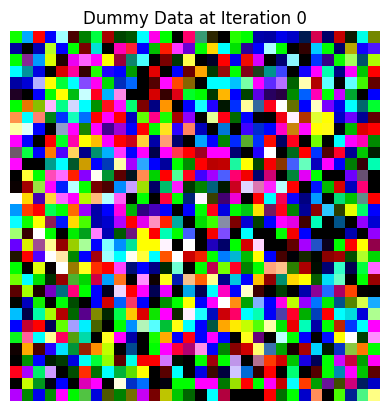

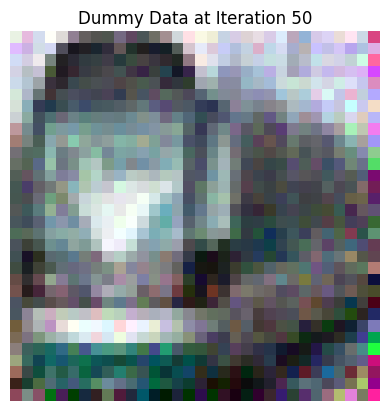

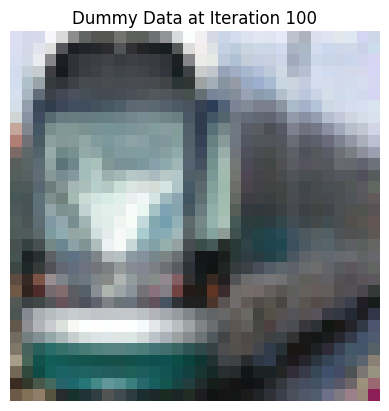

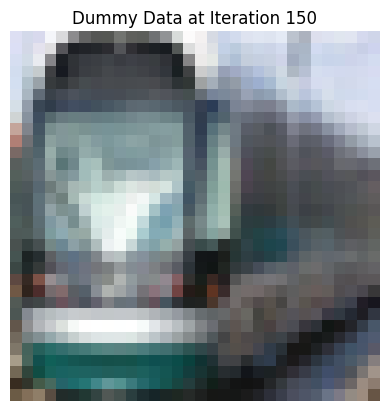

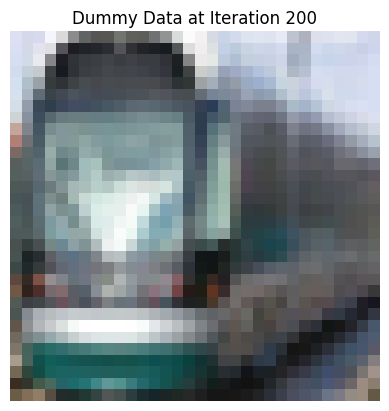

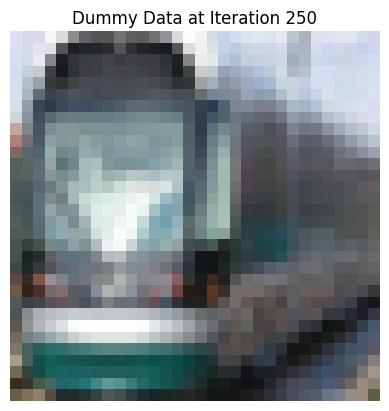

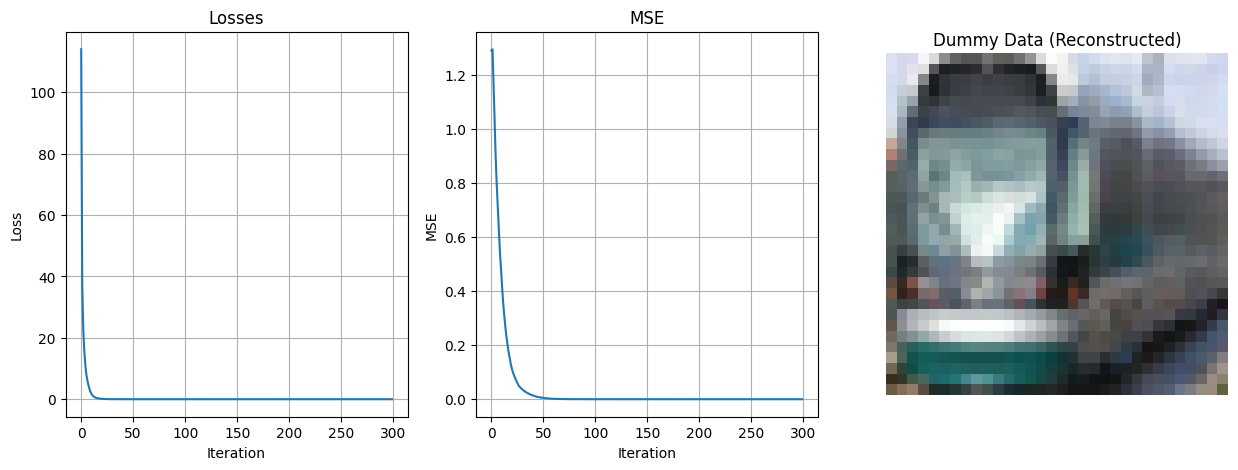

DLG Final Loss: 3.067174702664488e-06, MSE: 2.7252490326645784e-06


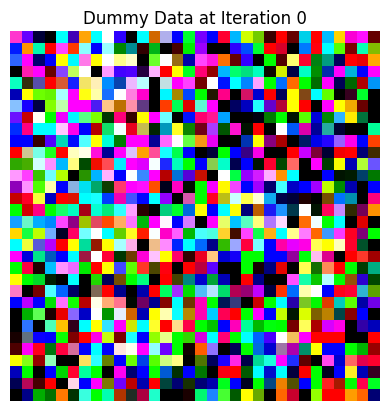

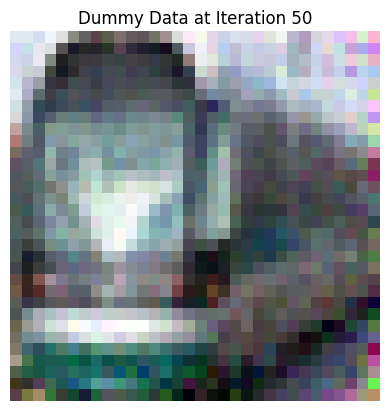

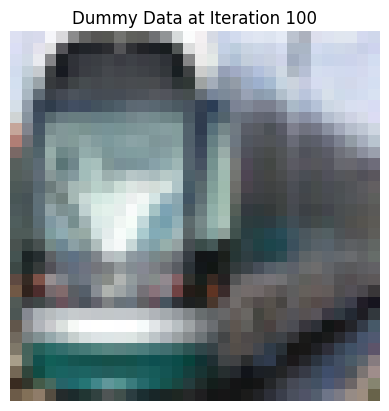

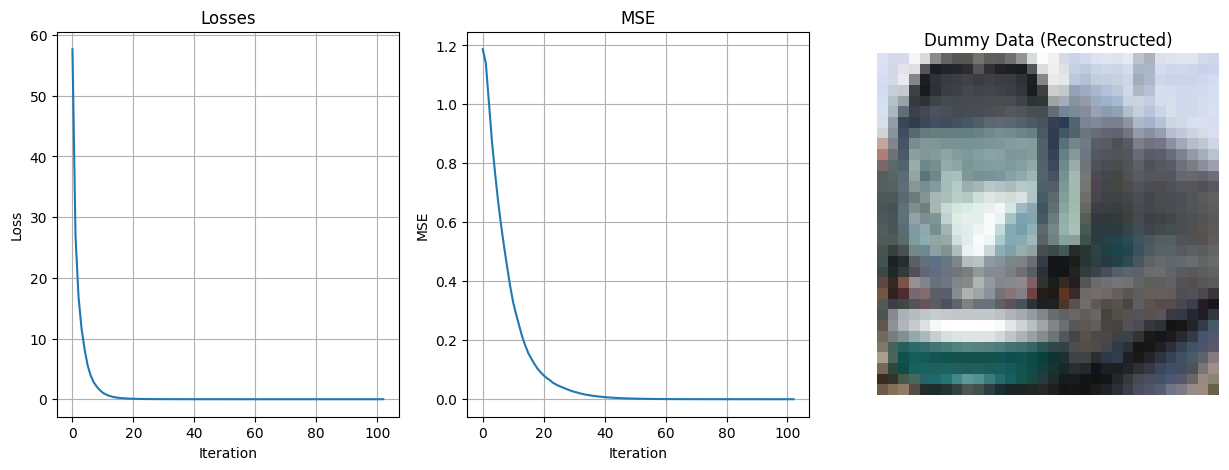

iDLG Final Loss: 9.177672382065793e-07, MSE: 4.534957497526193e-06
running 1|5 experiment


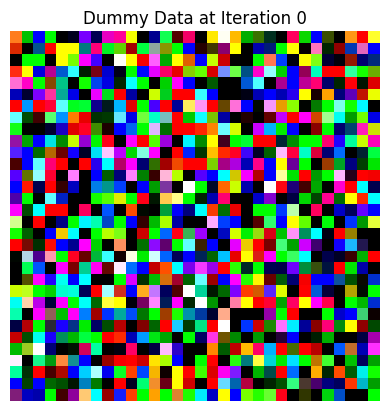

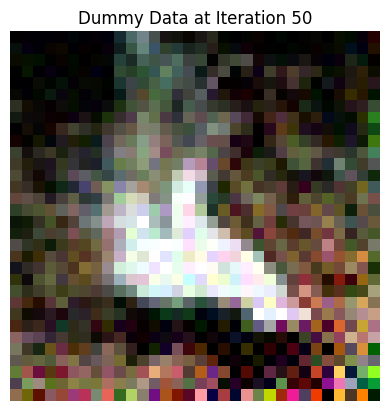

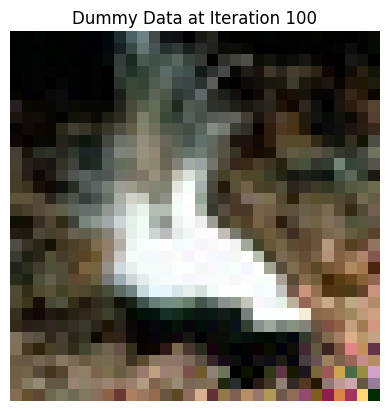

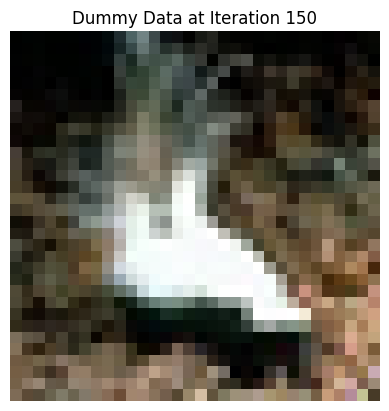

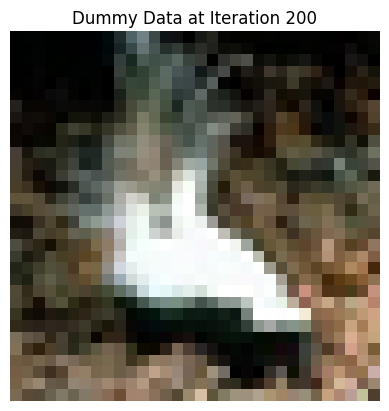

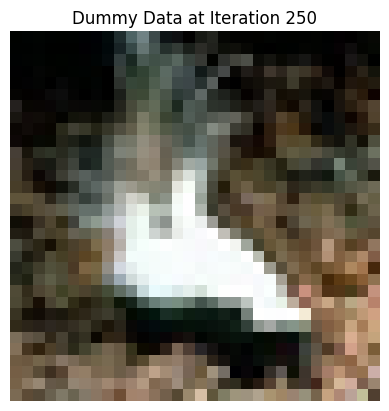

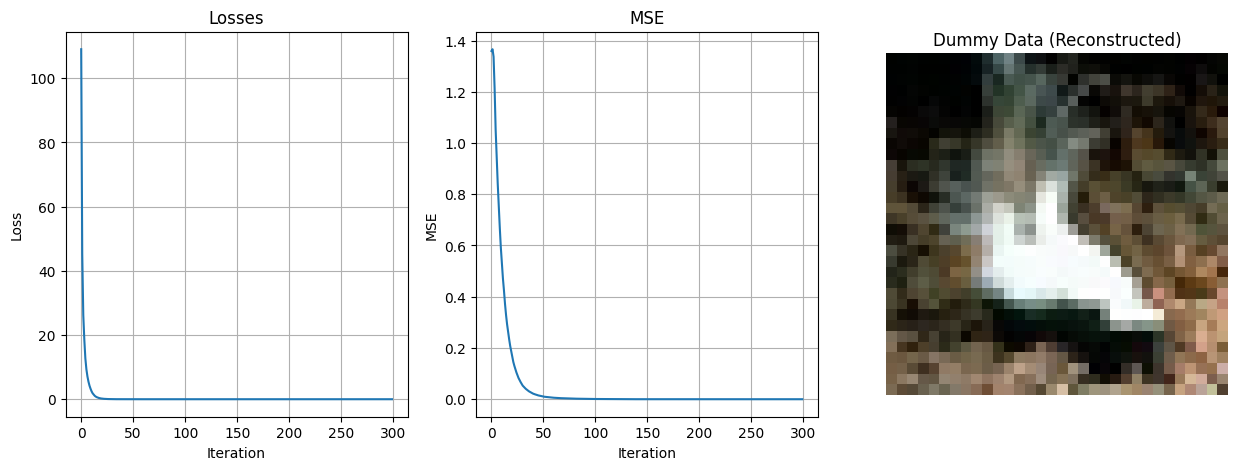

DLG Final Loss: 2.559943368396489e-06, MSE: 1.4286333680502139e-05


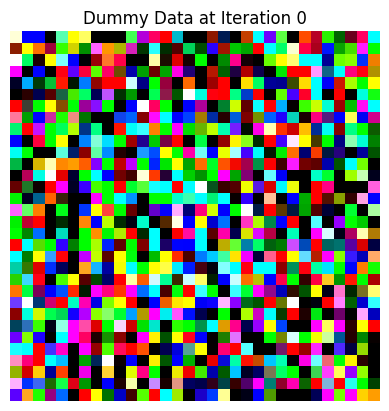

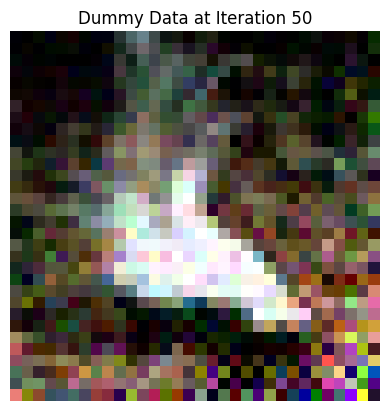

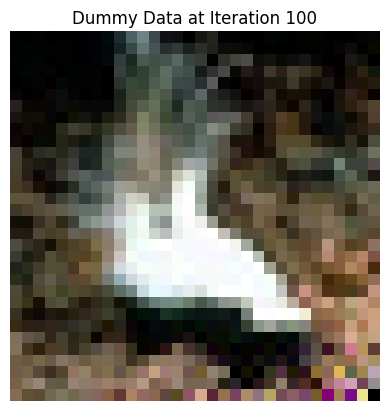

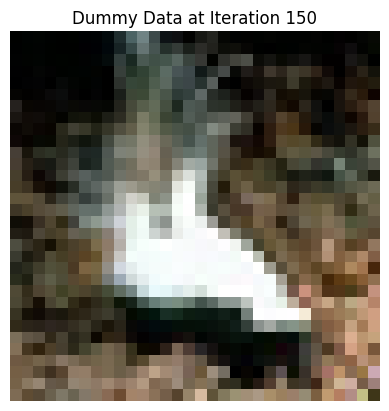

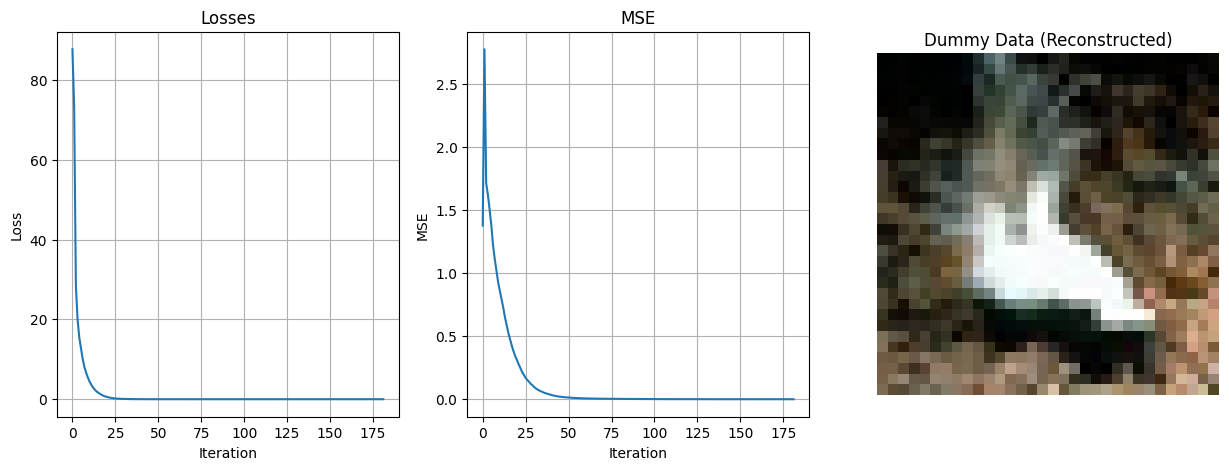

iDLG Final Loss: 9.823339723880053e-07, MSE: 1.6896266970434226e-05
running 2|5 experiment


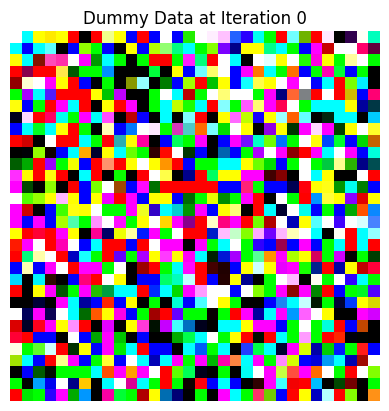

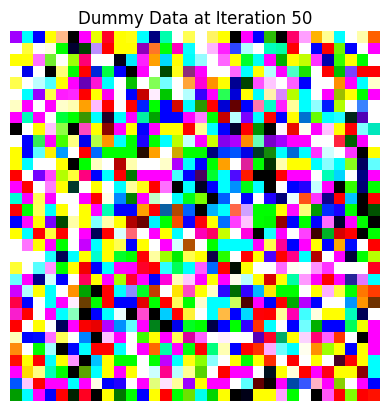

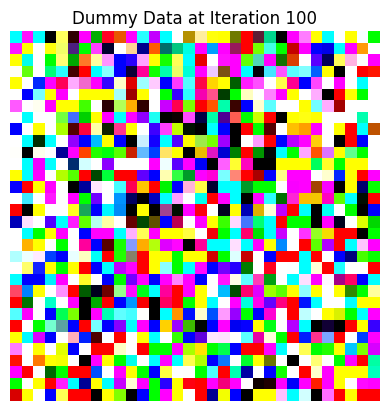

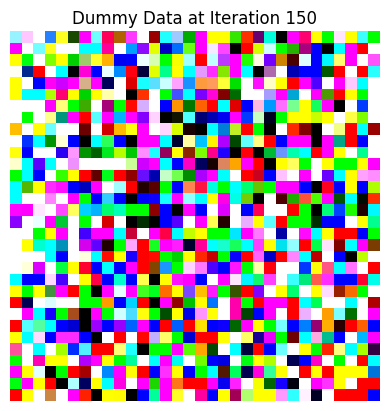

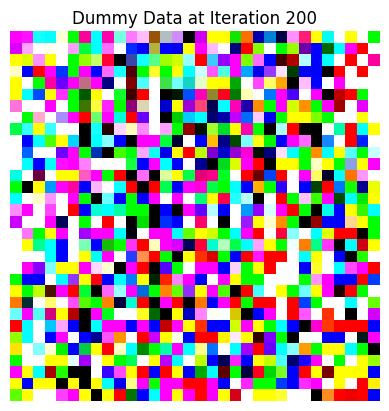

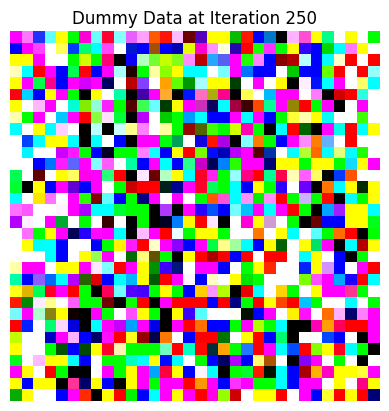

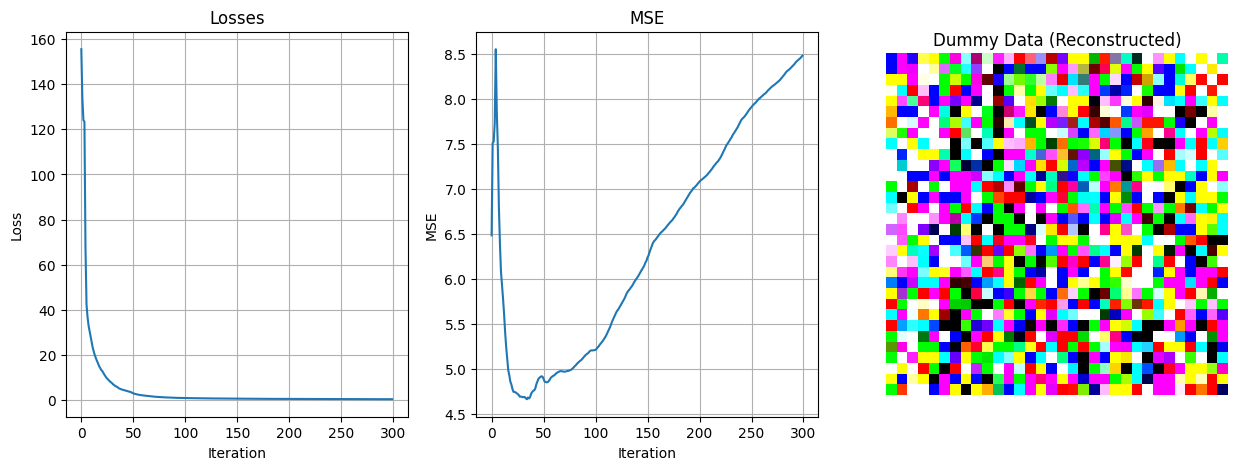

DLG Final Loss: 0.35050734877586365, MSE: 8.48031234741211


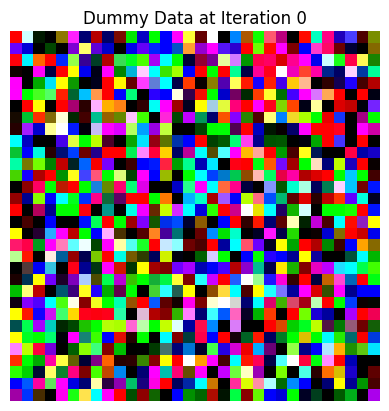

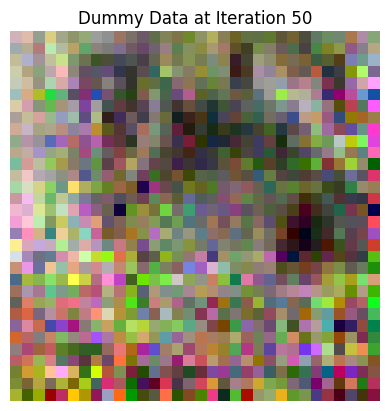

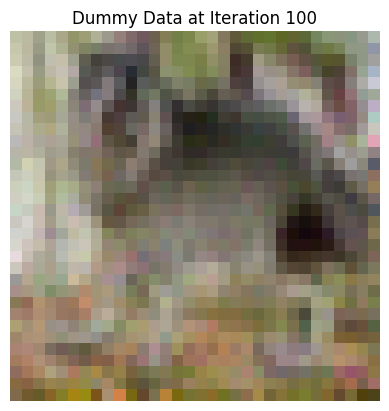

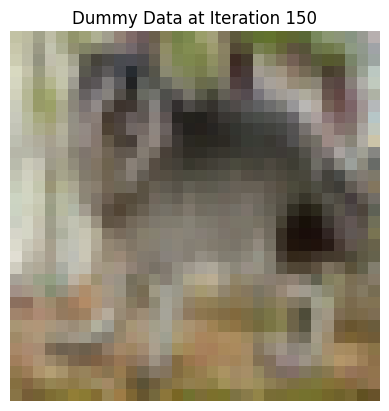

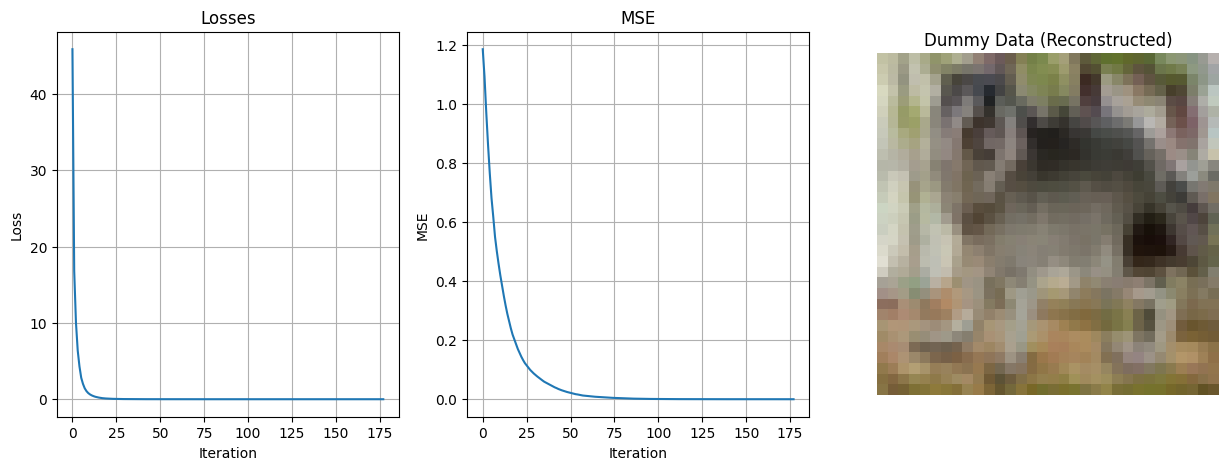

iDLG Final Loss: 9.920288448483916e-07, MSE: 2.1515928892767988e-05
running 3|5 experiment


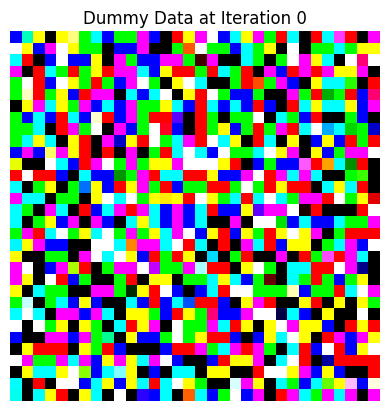

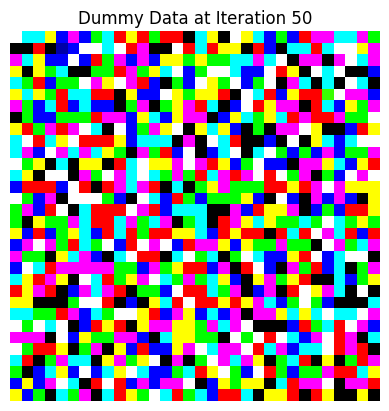

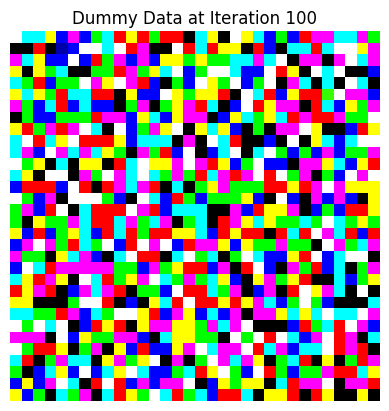

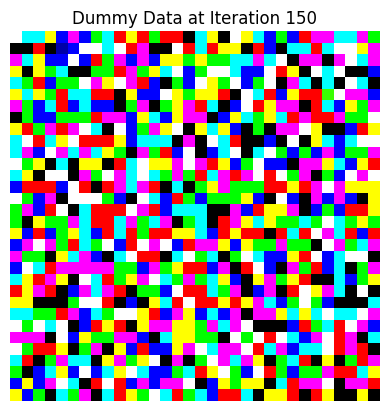

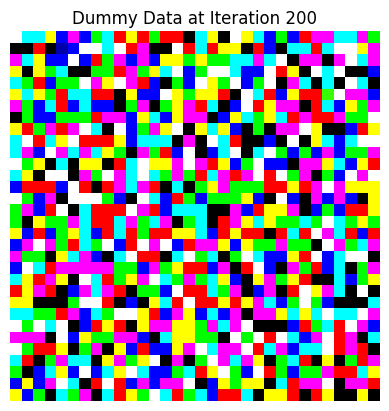

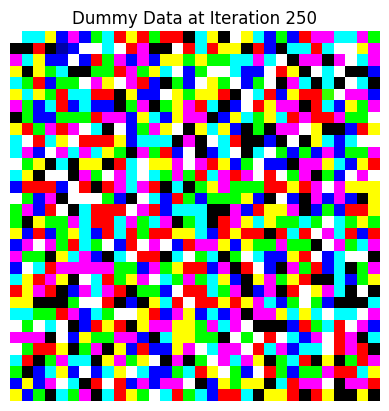

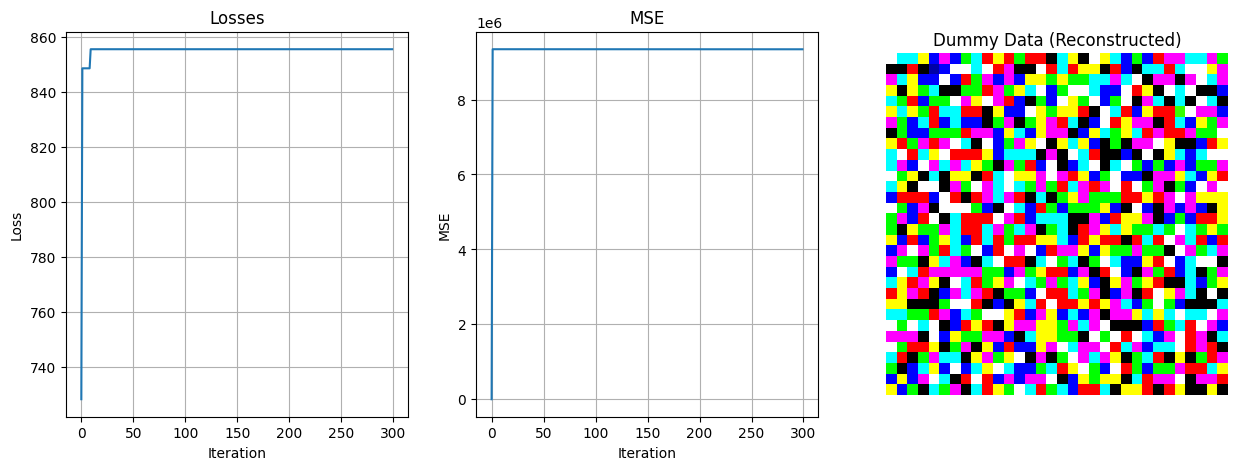

DLG Final Loss: 855.6089477539062, MSE: 9342570.0


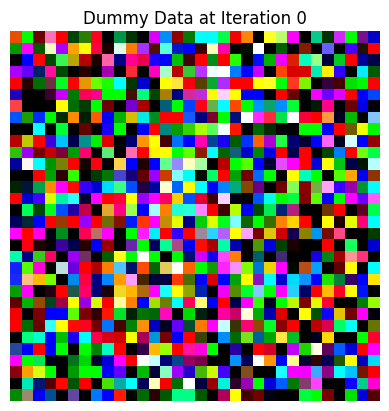

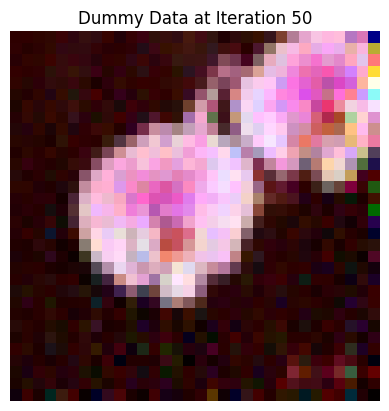

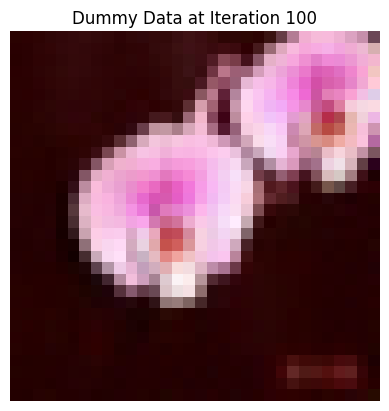

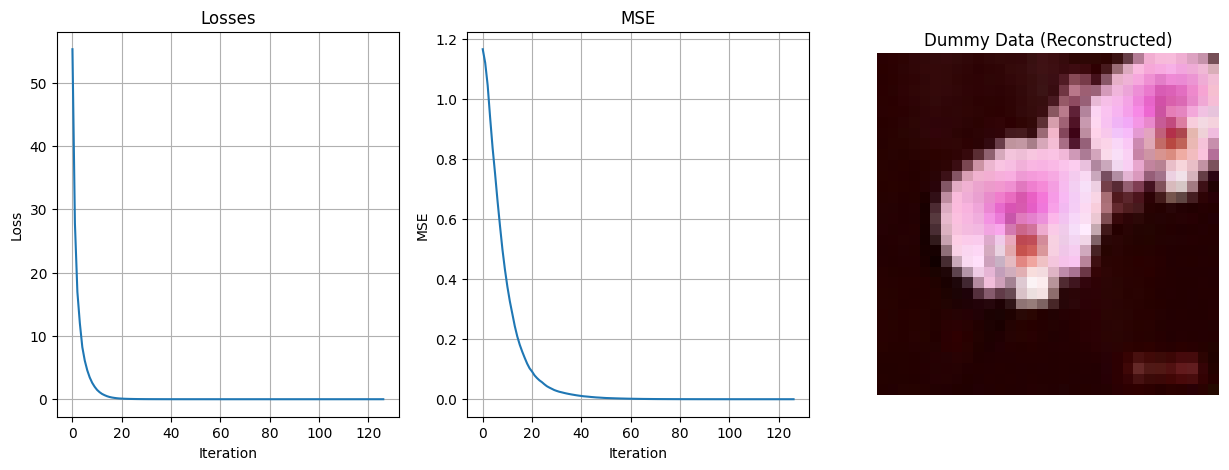

iDLG Final Loss: 9.569570238454617e-07, MSE: 7.204122084658593e-06
running 4|5 experiment


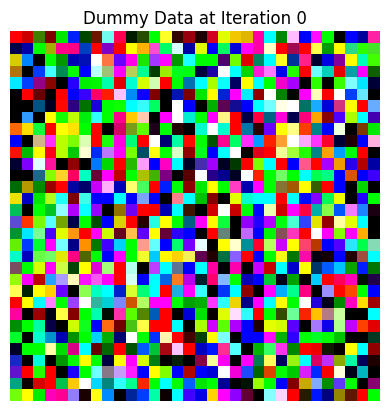

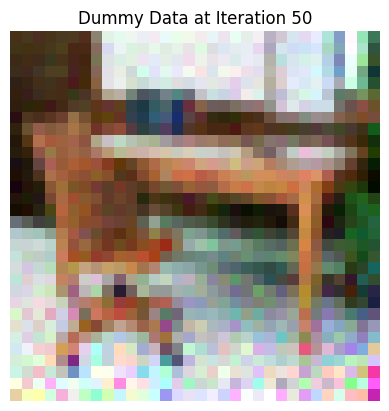

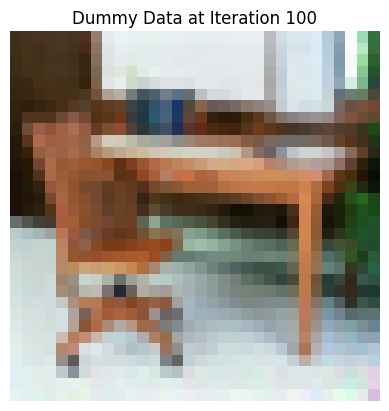

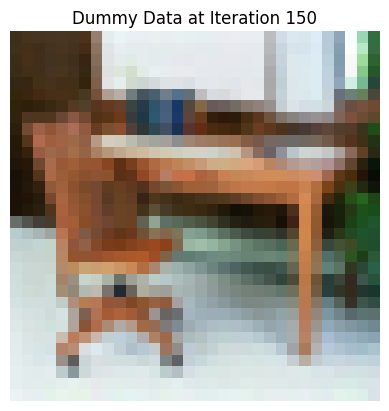

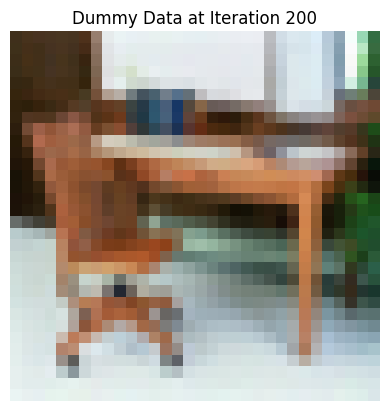

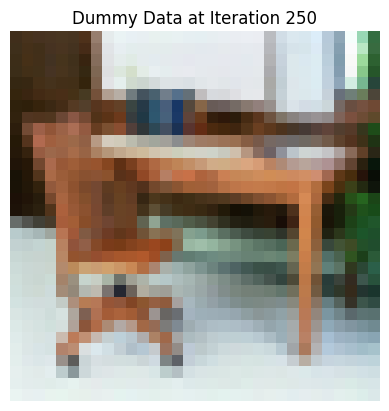

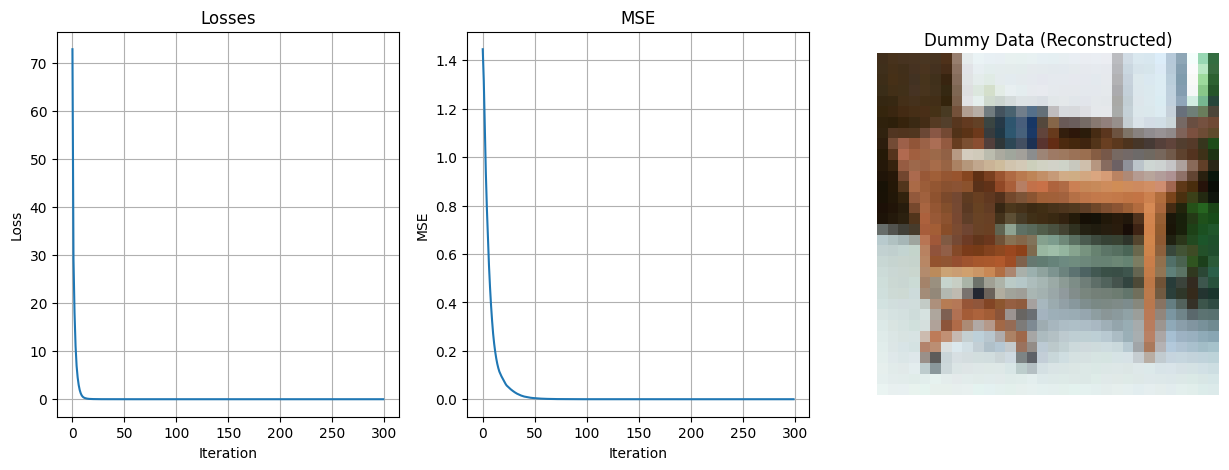

DLG Final Loss: 2.017327460634988e-06, MSE: 1.8133945332010626e-06


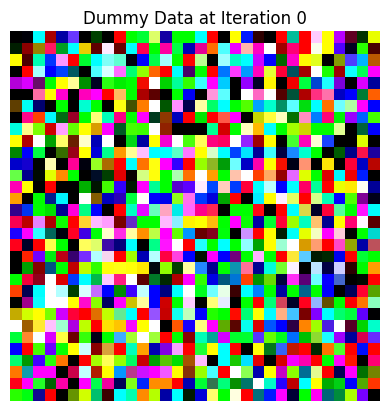

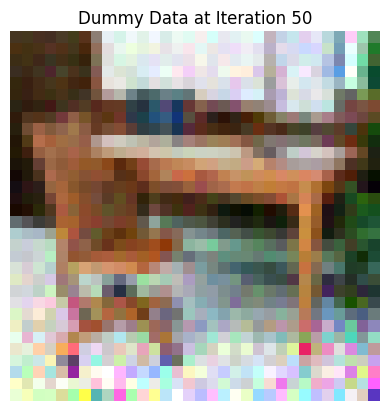

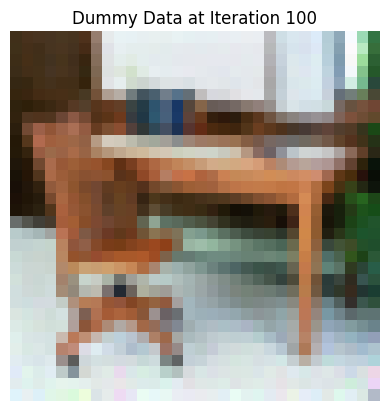

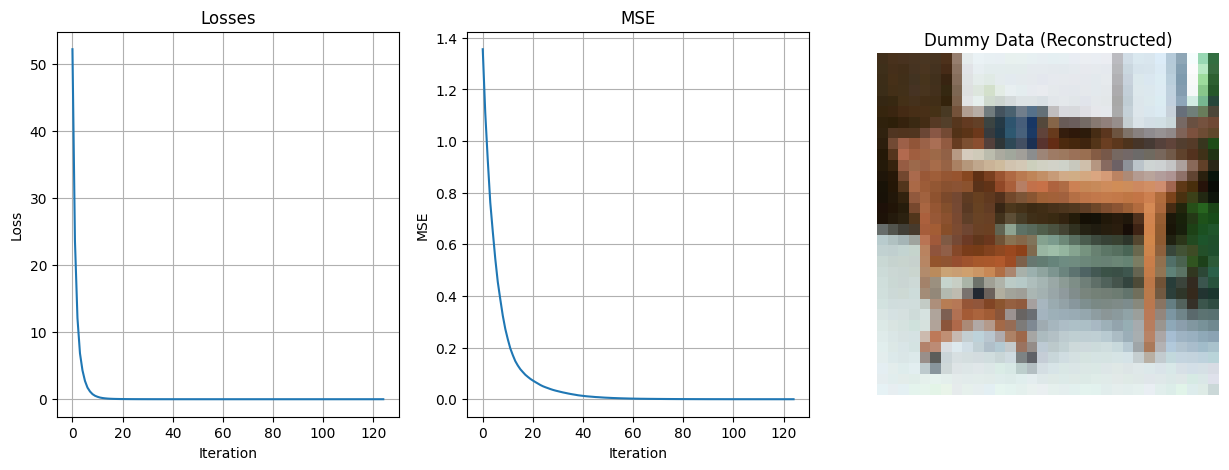

iDLG Final Loss: 9.668788152339403e-07, MSE: 1.4760898011445533e-05


In [ ]:
dataset = 'cifar100'
root_path = '~'
data_path = os.path.join(root_path, '/torch/cifar').replace('\\', '/')
save_path = os.path.join(root_path, '/results/iDLG_%s' % dataset).replace('\\', '/')

print(save_path)
print(data_path)

if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists('results'):
    os.makedirs('results')

print(dataset, 'root_path:', root_path)
print(dataset, 'data_path:', data_path)
print(dataset, 'save_path:', save_path)

#load data
dst, shape_img, num_classes, channel, hidden = load_data(dataset, root_path)

tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])


lr = 1.0
num_dummy = 1
Iteration = 300
num_exp = 5

def plot_results(losses, mses, dummy_data, gt_data, dataset):
    """
    绘制 Losses、MSE，以及最终 Dummy Data 图像
    """
    plt.figure(figsize=(15, 5))

    # 绘制 Losses
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title('Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()

    # 绘制 MSE
    plt.subplot(1, 3, 2)
    plt.plot(mses)
    plt.title('MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.grid()

    # 显示 Dummy Data 最终结果
    plt.subplot(1, 3, 3)
    dummy_img = dummy_data.detach().cpu().numpy()
    dummy_img = np.transpose(dummy_img[0], (1, 2, 0))  # 转换为 (height, width, channels)
    plt.imshow(dummy_img, cmap=None if dataset == 'cifar100' else 'gray')
    plt.title('Dummy Data (Reconstructed)')
    plt.axis('off')

    plt.show()


def plot_dummy_data(dummy_data, iteration, dataset):
    """
    显示重组过程中 Dummy Data 的图像
    """
    # 将 dummy_data 从 (batch_size, channels, height, width) 转换为 (height, width, channels)
    dummy_img = dummy_data.detach().cpu().numpy()
    dummy_img = np.transpose(dummy_img[0], (1, 2, 0))  # 取第一个样本并调整维度顺序

    # 如果是 CIFAR-100，图像是 RGB，不需要灰度模式
    plt.imshow(dummy_img, cmap=None if dataset == 'cifar100' else 'gray')
    plt.axis('off')
    plt.title(f'Dummy Data at Iteration {iteration}')
    plt.show()


for idx_net in range(num_exp):
    net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
    net.apply(weights_init)

    print('running %d|%d experiment'%(idx_net, num_exp))
    net = net.to(device)
    idx_shuffle = np.random.permutation(len(dst))

    for method in ['DLG', 'iDLG']:
        criterion = nn.CrossEntropyLoss().to(device)

        gt_data, gt_label = None, None
        imidx_list = []
        for imidx in range(num_dummy):
            idx = idx_shuffle[imidx]
            imidx_list.append(idx)
            tmp_datum = tt(dst[idx][0]).float().to(device)
            tmp_datum = tmp_datum.view(1, *tmp_datum.size())
            tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
            tmp_label = tmp_label.view(1, )
            if imidx == 0:
                gt_data = tmp_datum
                gt_label = tmp_label
            else:
                gt_data = torch.cat((gt_data, tmp_datum), dim=0)
                gt_label = torch.cat((gt_label, tmp_label), dim=0)

        original_dy_dx = compute_original_gradient(net, gt_data, gt_label, criterion)


        if method == 'DLG':
            losses, mses, dummy_data = train_DLG(net, gt_data, gt_label, original_dy_dx, num_classes, device, lr, Iteration)
        elif method == 'iDLG':
            losses, mses, dummy_data = train_iDLG(net, gt_data, gt_label, original_dy_dx, device, lr, Iteration)

        plot_results(losses, mses, dummy_data, gt_data, dataset)
        print(f'{method} Final Loss: {losses[-1]}, MSE: {mses[-1]}')